In [4]:
## Heatmaps Erstellung
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from pandas.errors import EmptyDataError

def make_heatmap(fix_df, size=800, bins=100, sigma=3):
    """
    Aus Fixation-DataFrame ein 2D-Histogramm erstellen, glätten und normalisieren.
    - fix_df: DataFrame mit Spalten 'x' und 'y' in Pixeln [0, size]
    - size: Pixelgröße des Stimulus (hier 800)
    - bins: Anzahl der Bins pro Achse für das Histogramm
    - sigma: Sigma für Gaussian-Glättung
    Rückgabe: 2D-Array Größe (bins, bins) mit Werten [0..1].
    """
    x = fix_df['x'].values
    y = fix_df['y'].values
    # 2D-Histogramm
    heatmap, _, _ = np.histogram2d(
        y, x,                       # y zuerst, damit image richtig orientiert
        bins=bins,
        range=[[0, size], [0, size]],
        density=False
    )
    # Glätten
    heatmap = gaussian_filter(heatmap, sigma=sigma)
    # Normieren (0..1)
    if heatmap.max() > 0:
        heatmap = heatmap / heatmap.max()
    return heatmap

def process_heatmaps(fixations_folder, heatmap_folder, size=800, bins=100, sigma=3):
    os.makedirs(heatmap_folder, exist_ok=True)
    pattern = os.path.join(fixations_folder, "*_fixations.csv")
    for path in glob.glob(pattern):
        # 1) Versuche einzulesen, skippe komplett leere oder unlesbare Dateien
        try:
            df = pd.read_csv(path)
        except EmptyDataError:
            print(f"Skipping {os.path.basename(path)}: file is empty or has no header")
            continue

        # 2) Skippe, wenn Header da, aber keine Datenzeilen
        if df.empty:
            print(f"Skipping {os.path.basename(path)}: no fixations")
            continue

        # 3) Heatmap erstellen
        heat = make_heatmap(df, size=size, bins=bins, sigma=sigma)

        # 4) Plot & speichern
        plt.figure(figsize=(4,4))
        plt.imshow(heat, origin='lower', extent=[0, size, 0, size])
        plt.axis('off')
        base = os.path.splitext(os.path.basename(path))[0].replace("_fixations", "")
        out_png = os.path.join(heatmap_folder, f"{base}_heatmap.png")
        plt.savefig(out_png, bbox_inches='tight', pad_inches=0)
        plt.close()
        print(f"Saved heatmap: {os.path.basename(out_png)}")

# ==== Notebook-Aufruf ====
fix_folder     = "processed/fixations"
heatmap_folder = "processed/heatmaps"
process_heatmaps(fix_folder, heatmap_folder, size=800, bins=100, sigma=3)


Saved heatmap: P000_id001_meme_ncc_processed_heatmap.png
Saved heatmap: P000_id002_meme_ncc_processed_heatmap.png
Saved heatmap: P000_id003_meme_ncc_processed_heatmap.png
Saved heatmap: P000_id004_meme_ncc_processed_heatmap.png
Saved heatmap: P000_id005_meme_ncc_processed_heatmap.png
Saved heatmap: P000_id006_meme_ncc_processed_heatmap.png
Saved heatmap: P000_id007_meme_ncc_processed_heatmap.png
Saved heatmap: P000_id008_meme_ncc_processed_heatmap.png
Saved heatmap: P000_id009_meme_ncc_processed_heatmap.png
Saved heatmap: P000_id010_meme_ncc_processed_heatmap.png
Saved heatmap: P000_id011_ort_processed_heatmap.png
Saved heatmap: P000_id012_ort_processed_heatmap.png
Saved heatmap: P000_id013_ort_processed_heatmap.png
Saved heatmap: P000_id014_ort_processed_heatmap.png
Saved heatmap: P000_id015_ort_processed_heatmap.png
Saved heatmap: P000_id016_ort_processed_heatmap.png
Saved heatmap: P000_id017_ort_processed_heatmap.png
Saved heatmap: P000_id018_ort_processed_heatmap.png
Saved heatmap:

Skipping P013_id012_ort_processed: file empty or no header
Skipping P013_id015_ort_processed: file empty or no header
Skipping P013_id022_ort_processed: file empty or no header
Skipping P013_id025_ort_processed: file empty or no header
Skipping P013_id032_ort_processed: file empty or no header
Skipping P013_id033_person_processed: file empty or no header
Skipping P013_id045_person_processed: file empty or no header
Skipping P013_id047_person_processed: file empty or no header
Skipping P013_id062_person_processed: file empty or no header
Skipping P013_id077_person_processed: file empty or no header
Skipping P013_id104_politik_processed: file empty or no header
Skipping P013_id115_textimg_meme_ncc_processed: file empty or no header
Skipping P013_id123_textimg_meme_ncc_processed: file empty or no header
Skipping P013_id126_text_politik_processed: file empty or no header
Skipping P013_id129_textimg_ort_processed: file empty or no header
Skipping P013_id135_textimg_politik_processed: file e

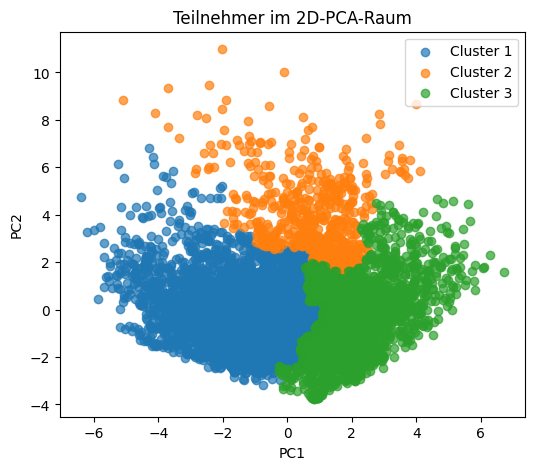

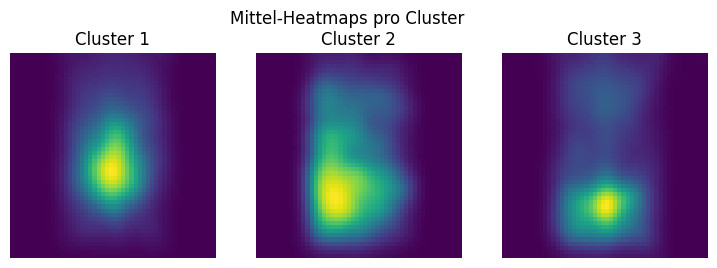

In [5]:
import os
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from scipy.cluster.hierarchy import linkage, fcluster
from numpy.linalg import svd
from pandas.errors import EmptyDataError

def make_heatmap(fix_df, size=800, bins=50, sigma=2):
    x, y = fix_df['x'], fix_df['y']
    H, _, _ = np.histogram2d(
        y, x,
        bins=bins,
        range=[[0, size], [0, size]],
        density=False
    )
    H = gaussian_filter(H, sigma=sigma)
    return H / H.max() if H.max() > 0 else H

def pca_manual(X, n_components=2):
    Xc = X - X.mean(axis=0)
    U, S, VT = svd(Xc, full_matrices=False)
    return Xc.dot(VT.T[:, :n_components])

def cluster_hierarchy(X_red, k=3):
    Z = linkage(X_red, method='ward')
    labels = fcluster(Z, t=k, criterion='maxclust') - 1
    return labels

# === Workflow ===
fix_folder = "processed/fixations"
heatmaps   = []
ids        = []

for path in glob.glob(os.path.join(fix_folder, "*_fixations.csv")):
    subj = os.path.basename(path).replace("_fixations.csv", "")
    
    # 1) Datei nur einlesen, wenn sie tatsächlich Header + Daten enthält
    try:
        df = pd.read_csv(path)
    except EmptyDataError:
        print(f"Skipping {subj}: file empty or no header")
        continue
    
    if df.empty:
        print(f"Skipping {subj}: no fixation rows")
        continue

    # 2) Heatmap-Feature erzeugen
    H = make_heatmap(df)
    heatmaps.append(H.flatten())
    ids.append(subj)

if not heatmaps:
    raise RuntimeError("Keine gültigen Fixations-Dateien gefunden.")

X = np.vstack(heatmaps)
X_red = pca_manual(X, n_components=2)

# 3) Clustering (hier k=3 als Beispiel)
labels = cluster_hierarchy(X_red, k=3)

# === Visualisierung ===

# 3a) 2D-PCA-Scatter
plt.figure(figsize=(6,5))
for lbl in np.unique(labels):
    idx = labels == lbl
    plt.scatter(X_red[idx,0], X_red[idx,1], label=f"Cluster {lbl+1}", alpha=0.7)
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.title("Teilnehmer im 2D-PCA-Raum")
plt.show()

# 3b) Durchschnitts-Heatmap pro Cluster
n_clusters = labels.max() + 1
fig, axes = plt.subplots(1, n_clusters, figsize=(3*n_clusters,3))
bins = int(np.sqrt(heatmaps[0].size))
for c in range(n_clusters):
    group_idx = [i for i, lab in enumerate(labels) if lab == c]
    mean_H = np.mean([heatmaps[i].reshape((bins, bins)) for i in group_idx], axis=0)
    ax = axes[c] if n_clusters > 1 else axes
    ax.imshow(mean_H, origin='lower', extent=[0,800,0,800])
    ax.set_title(f"Cluster {c+1}")
    ax.axis('off')
fig.suptitle("Mittel-Heatmaps pro Cluster")
plt.show()
